# Case Study 3

#### Predicting Central Neuropathic Pain (CNP) in people with Spinal Cord Injury (SCI) from Electroencephalogram (EEG) data.

* CNP is pain in response to non-painful stimuli, episodic (electric shock), “pins and needles”, numbness
* There is currently no treatment, only prevention
* Preventative medications have strong side-effects
* Predicting whether a patient is likely to develop pain is useful for selective treatment

#### Task
Your task is to devise a feature engineering strategy which, in combination with a classifier of your choice, optizimes prediction accuracy.

#### Data
The data is preprocessed brain EEG data from SCI patients recorded while resting with eyes closed (EC) and eyes opened (EO).
* 48 electrodes recording electrical activity of the brain at 250 Hz 
* 2 classes: subject will / will not develop neuropathic pain within 6 months
* 18 subjects: 10 developed pain and 8 didn’t develop pain
* the data has already undergone some preprocessing
  * Signal denoising and normalization
  * Temporal segmentation
  * Frequency band power estimation
  * Normalization with respect to total band power
  * Features include normalized alpha, beta, theta band power while eyes closed, eyes opened, and taking the ratio of eo/ec.
* the data is provided in a single table ('data.csv') consisting of 
  * 180 rows (18 subjects x 10 repetitions), each containing
  * 432 columns (9 features x 48 electrodes)
  * rows are in subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
  * columns are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
  * feature identifiers for all columns are stored in 'feature_names.csv'
  * 'labels.csv' defines the corresponding class (0 or 1) to each row in data.csv

#### Objective Measure
Leave one subject out cross-validation accuracy, sensitivity and specificity.

#### Report
Report on your feature engineering pipeline, the classifier used to evaluate performance, and the performance as mean and standard deviation of accuracy, sensitivity and specificity across folds. Give evidence for why your strategy is better than others.

#### Requirements

  * compare at least 2 feature selection methods (groups of 5-6: at least 4)
    - filtering methods (at least one scoring function)
    - wrapper methods (at least one, e.g., forward feature selection or backward feature elimination)
    - embedding methods  (at least one, e.g., L1 regularisation)
 * combine each method with at least 2 classifiers 
   (justify your choice of classifiers in the report)
    - SVM
    - KNN
    - ...
  * perform Leave-one-group-out cross-validation, where all 10 samples from each subject are in one group (18 groups in total)
  * use cross-validation to optimise hyper-parameter values
  * as a baseline for comparison, evaluate each of your classifiers trained on the full set of features (trained without feature selection)




In [1]:
import csv
import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneGroupOut,GridSearchCV,cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif, f_regression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

In [2]:
# load data
# rows in X are subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
# columns in X are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
# feature identifiers for all columns in X are stored in feature_names.csv
X = np.loadtxt('data.csv', delimiter=',') 
y = np.loadtxt('labels.csv', delimiter=',')
with open('feature_names.csv') as f:
    csvreader = csv.reader(f, delimiter=',')
    feature_names = [row for row in csvreader][0]

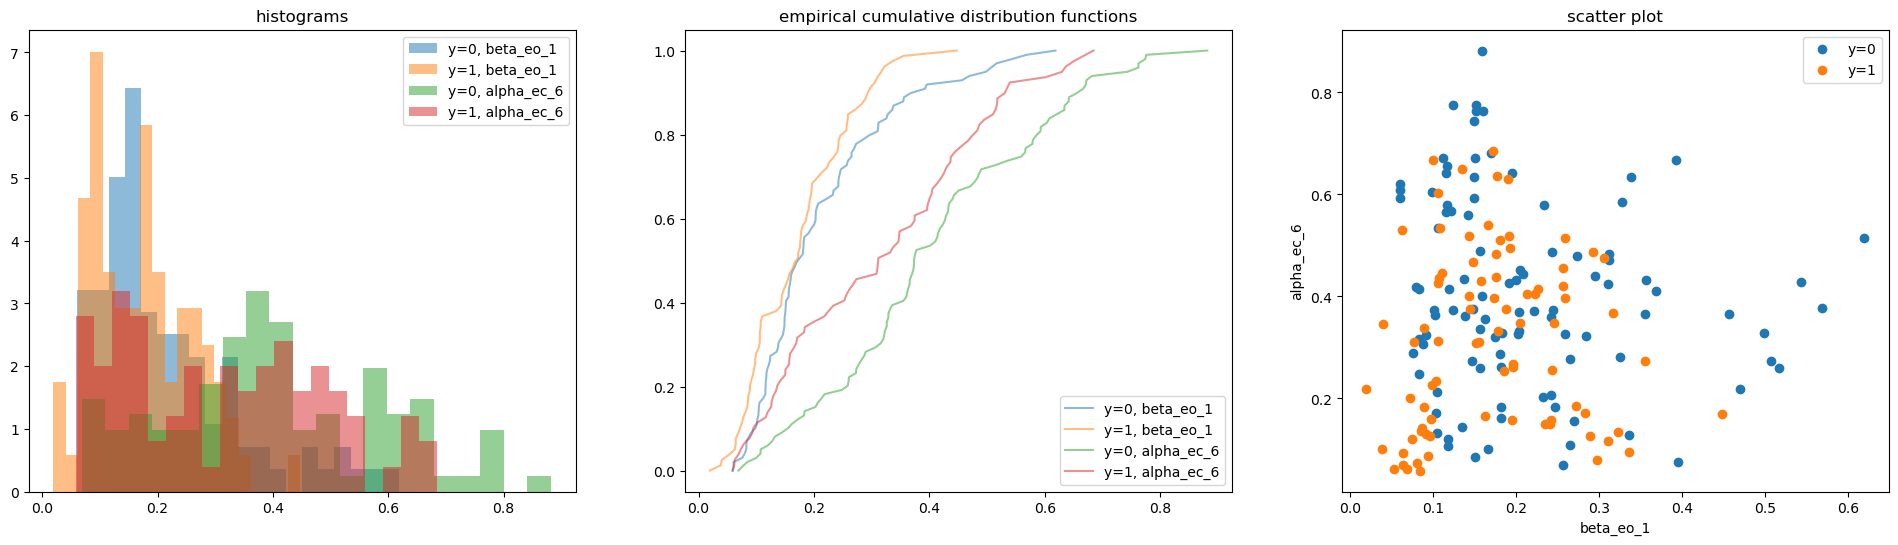

In [3]:
# plotting data in 2D with axes sampled 
# a) at random 
# b) from same electrode
# c) from same feature type
num_features = 9
num_electrodes = 48

# a) indices drawn at random
i0, i1 = np.random.randint(0, X.shape[1], size=2)

# b) same electrode, different feature (uncomment lines below)
#f0, f1 = np.random.randint(0, num_features, size=2)
#e = np.random.randint(0, num_electrodes)
#i0, i1 = f0*num_electrodes + e, f1*num_electrodes + e

# b) same feature, different electrode (uncomment lines below)
#f = np.random.randint(0, num_features)
#e0, e1 = np.random.randint(0, num_electrodes, size=2)
#i0, i1 = f*num_electrodes + e0, f*num_electrodes + e1

fig, axes = plt.subplots(1, 3, figsize=(24, 6))
colors = ['blue', 'red']

# select features i0, i1 and separate by class
X00, X01 = X[y==0][:,i0], X[y==1][:,i0]
X10, X11 = X[y==0][:,i1], X[y==1][:,i1]
# plot cumulative distribution of feature i0 separate for each class
axes[0].hist(X00, bins=20, label='y=0, '+ feature_names[i0], density=True, alpha=0.5)
axes[0].hist(X01, bins=20, label='y=1, '+ feature_names[i0], density=True, alpha=0.5)
axes[0].hist(X10, bins=20, label='y=0, '+ feature_names[i1], density=True, alpha=0.5)
axes[0].hist(X11, bins=20, label='y=1, '+ feature_names[i1], density=True, alpha=0.5)
axes[0].set_title('histograms')
axes[0].legend()
axes[1].plot(np.sort(X00), np.linspace(0,1,X00.shape[0]), label='y=0, '+ feature_names[i0], alpha=0.5)
axes[1].plot(np.sort(X01), np.linspace(0,1,X01.shape[0]), label='y=1, '+ feature_names[i0], alpha=0.5)
axes[1].plot(np.sort(X10), np.linspace(0,1,X10.shape[0]), label='y=0, '+ feature_names[i1], alpha=0.5)
axes[1].plot(np.sort(X11), np.linspace(0,1,X11.shape[0]), label='y=1, '+ feature_names[i1], alpha=0.5)
axes[1].set_title('empirical cumulative distribution functions')
axes[1].legend()
axes[2].scatter(X00, X10, label='y=0')
axes[2].scatter(X01, X11, label='y=1')
axes[2].set_xlabel(feature_names[i0])
axes[2].set_ylabel(feature_names[i1])
axes[2].set_title('scatter plot')
axes[2].legend()

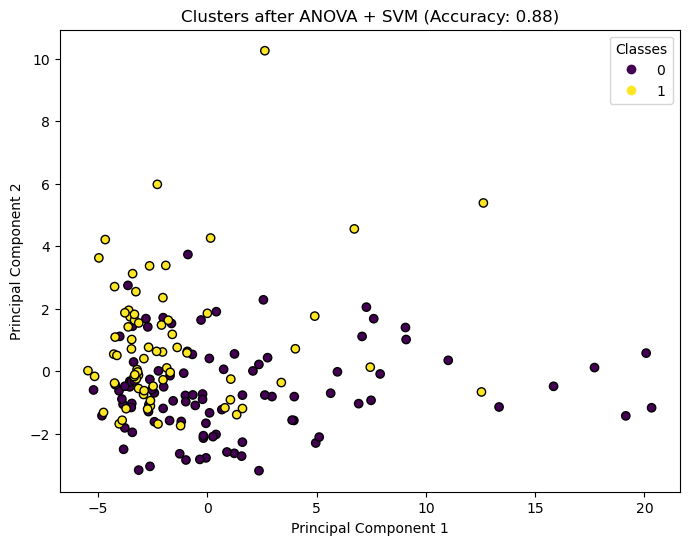

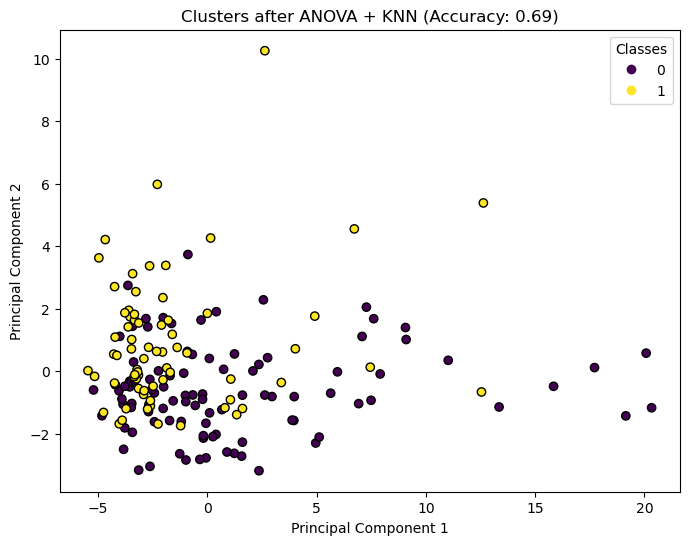

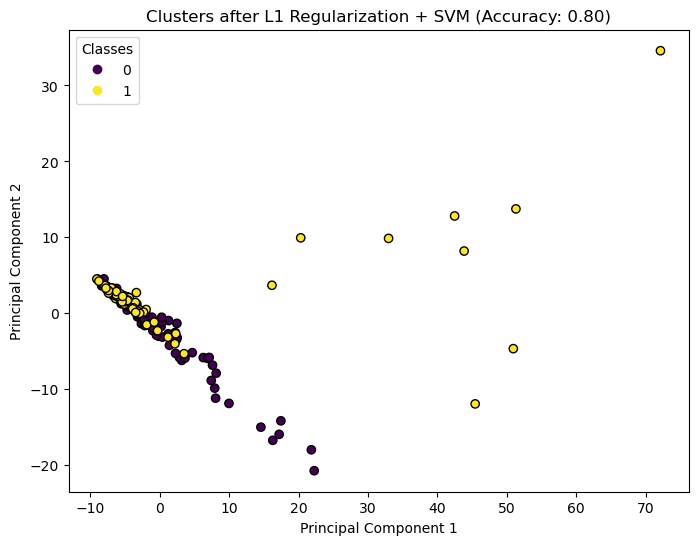

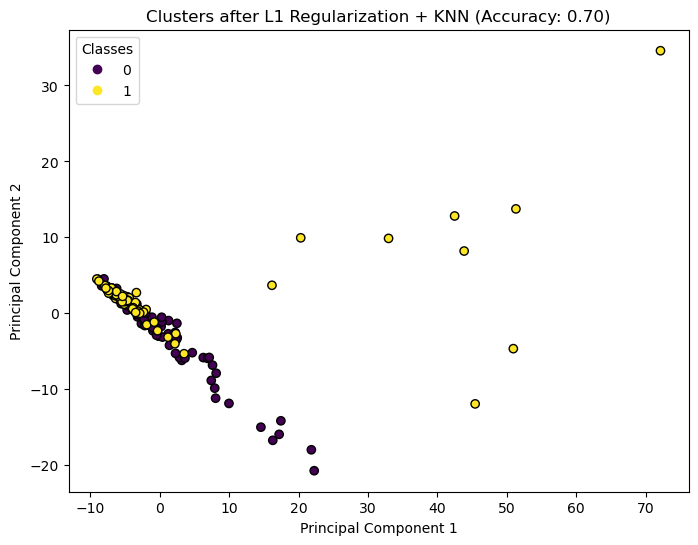

ANOVA + SVM Results:
  Accuracy: 0.88
  Sensitivity: 0.85
  Specificity: 0.91
  Best Hyperparameters: {'C': 10}
---
ANOVA + KNN Results:
  Accuracy: 0.69
  Sensitivity: 0.64
  Specificity: 0.74
  Best Hyperparameters: {'n_neighbors': 9}
---
L1 Regularization + SVM Results:
  Accuracy: 0.80
  Sensitivity: 0.78
  Specificity: 0.82
  Best Hyperparameters: {'C': 1}
---
L1 Regularization + KNN Results:
  Accuracy: 0.70
  Sensitivity: 0.65
  Specificity: 0.74
  Best Hyperparameters: {'n_neighbors': 7}
---
Full Set + SVM Results:
  Accuracy: 0.71
---
Full Set + KNN Results:
  Accuracy: 0.69
---


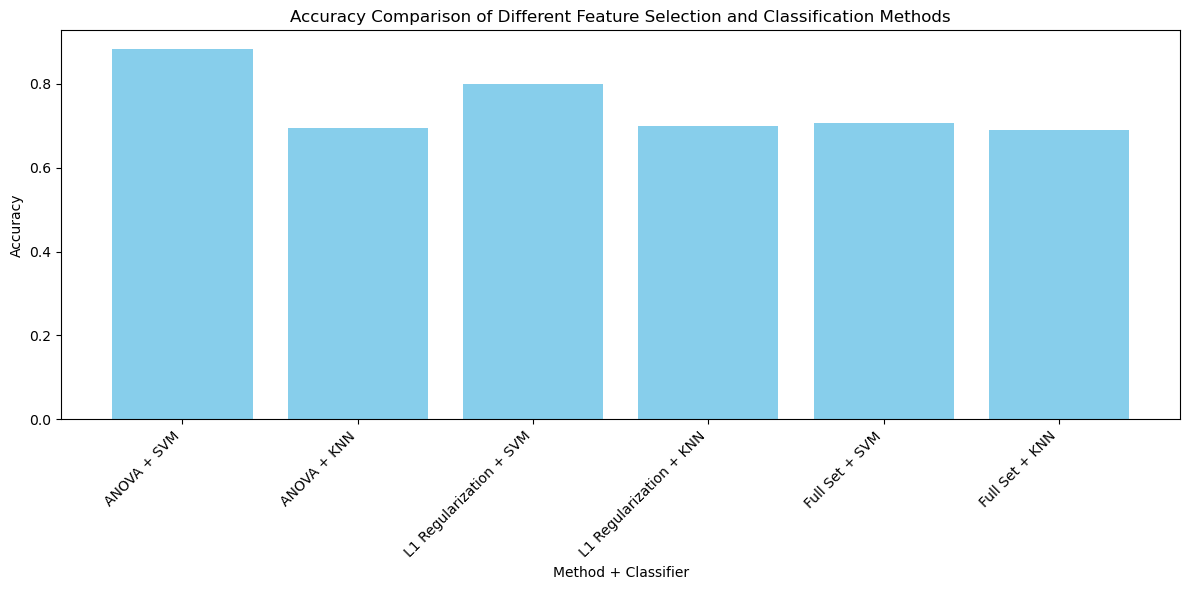

In [4]:

# Leave-One-Subject-Out Cross-Validation
logo = LeaveOneGroupOut()

# Feature Selection and Classification
feature_selection_methods = {
    'Pearson Correlation': SelectKBest(f_classif, k=100),
    'Chi-Square': SelectKBest(chi2, k=100),
    'ANOVA': SelectKBest(f_classif, k=100),
    'L1 Regularization': LogisticRegression(penalty='l1', solver='liblinear', random_state=0)
}

classifiers = {
    'SVM': {
        'model': SVC(kernel='linear', class_weight='balanced', random_state=0),
        'params': {'C': [0.1, 1, 10, 100]}
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {'n_neighbors': [3, 5, 7, 9]}
    }
}

# Initialize Results Dictionary
results = {}
subject_groups = np.repeat(np.arange(18), 10)

for method_name, method in feature_selection_methods.items():
    for clf_name, clf_info in classifiers.items():
        clf = clf_info['model']
        params = clf_info['params']

        # Grid Search for Hyperparameter Tuning
        grid_search = GridSearchCV(clf, params, cv=LeaveOneGroupOut(), scoring='accuracy')
        # Initialize arrays to store predictions and true labels
        all_predictions = np.zeros_like(y)
        all_true_labels = np.zeros_like(y)

        for subject_id in np.unique(subject_groups):
            # Split data into training and testing sets based on the subject
            train_idx = np.where(subject_groups != subject_id)
            test_idx = np.where(subject_groups == subject_id)

            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # Feature Selection
            method.fit(X_train, y_train)
            
            if method_name == 'L1 Regularization':
                # For L1 Regularization, we consider non-zero coefficients as selected features
                selected_features = np.where(method.coef_[0] != 0)[0]
                X_train_selected = X_train[:, selected_features]
                X_test_selected = X_test[:, selected_features]
            else:
                # For other methods, use the transform method
                X_train_selected = method.transform(X_train)
                X_test_selected = method.transform(X_test)
                

            # Hyperparameter Tuning
            grid_search = GridSearchCV(clf, params, cv=5, scoring='accuracy')
            grid_search.fit(X_train_selected, y_train)
            best_params = grid_search.best_params_
            best_clf = grid_search.best_estimator_

            # Classifier Training
            best_clf.fit(X_train_selected, y_train)

            # Prediction
            y_pred = best_clf.predict(X_test_selected)

            # Store Predictions and True Labels
            all_predictions[test_idx] = y_pred
            all_true_labels[test_idx] = y_test
            
    
        # Performance Evaluation
        accuracy = accuracy_score(all_true_labels, all_predictions)
        confusion_mat = confusion_matrix(all_true_labels, all_predictions)
        sensitivity = confusion_mat[1, 1] / (confusion_mat[1, 0] + confusion_mat[1, 1])
        specificity = confusion_mat[0, 0] / (confusion_mat[0, 0] + confusion_mat[0, 1])

        # Store Results
        results[f'{method_name} + {clf_name}'] = {
            'Accuracy': accuracy,
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'Best Hyperparameters': best_params
        }

        # Dimensionality reduction for visualization
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_train_selected)

        # Plotting the clusters
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='viridis', edgecolor='k')
        plt.title(f'Clusters after {method_name} + {clf_name} (Accuracy: {accuracy:.2f})')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.legend(*scatter.legend_elements(), title='Classes')
        plt.show()
        
        
# Baseline evaluation on the full set of features
full_set_clf = SVC(kernel='linear', class_weight='balanced', random_state=0)
logo = LeaveOneGroupOut()
cv_results = cross_val_score(grid_search, X_train_selected, y_train, groups=subject_groups[train_idx], cv=logo, scoring='accuracy')
results['Full Set + SVM'] = {'Accuracy': np.mean(cv_results)}

# Baseline evaluation on the full set of features for KNN
full_set_knn_clf = KNeighborsClassifier()
cv_results_knn = cross_val_score(full_set_knn_clf, X, y, groups=subject_groups, cv=logo, scoring='accuracy')
results['Full Set + KNN'] = {'Accuracy': np.mean(cv_results_knn)}

# Getting Results
for method_clf, metrics in results.items():
    print(f'{method_clf} Results:')
    print(f'  Accuracy: {metrics["Accuracy"]:.2f}')
    if 'Sensitivity' in metrics:
        print(f'  Sensitivity: {metrics["Sensitivity"]:.2f}')
        print(f'  Specificity: {metrics["Specificity"]:.2f}')
        print(f'  Best Hyperparameters: {metrics["Best Hyperparameters"]}')
    print('---')
    
method_names = list(results.keys())
accuracy_values = [result['Accuracy'] for result in results.values()]

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(method_names, accuracy_values, color='skyblue')
plt.xlabel('Method + Classifier')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Different Feature Selection and Classification Methods')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
